# Import libraries and model

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gc
import gensim.downloader as api

import torch
import torch.nn as nn

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from math import ceil
import torch.optim as optim

import matplotlib.pyplot as plt
import datetime

nltk.download('stopwords')
nltk.download('wordnet')

# Load GloVe model with Gensim's API - Twitter specific embedding
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

#To check that T4 GPU is connected
#!nvidia-smi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data preprocessing and and feature extractions

## Preprocessing training set

In [355]:
# Read all training files and concatenate them into one dataframe

def load_data_frame(dirName):
    li = []
    i = 0
    for filename in listdir(dirName):
        if filename != '.ipynb_checkpoints':
            print(filename)
            df = pd.read_csv(dirName + "/" + filename)
            df.drop(columns=['Timestamp'], inplace=True)
            # Drop unused column(s)
            df['ID'] = df['MatchID'].astype(str) + '_' + df['PeriodID'].astype(str)
            #df['MatchID'] = str(i)
            # Makes sure that the match IDs are ordered from 0,1,2... with no missing values
            i+=1
            li.append(df)
    df = pd.concat(li, ignore_index=True)
    print("Loaded the dataframe from the folder " + dirName + "!")
    return df

In [356]:
df = load_data_frame("train_tweets")

ArgentinaBelgium72.csv
ArgentinaGermanyFinal77.csv
AustraliaNetherlands29.csv
AustraliaSpain34.csv
BelgiumSouthKorea59.csv
CameroonBrazil36.csv
FranceGermany70.csv
FranceNigeria66.csv
GermanyAlgeria67.csv
GermanyBrazil74.csv
GermanyUSA57.csv
HondurasSwitzerland54.csv
MexicoCroatia37.csv
NetherlandsChile35.csv
PortugalGhana58.csv
USASlovenia2010.csv
Loaded the dataframe from the folder train_tweets!


In [357]:
# Preprocessing of tweet
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def preprocess_data_frame(df):
    df['Tweet'] = df['Tweet'].apply(preprocess_text)
    df

In [358]:
# Apply preprocessing to each tweet
preprocess_data_frame(df)
df

,ID,MatchID,PeriodID,EventType,Tweet
0,11_0,11,0,0,rt woridcup argentina v belgium win httptcoleu...
1,11_0,11,0,0,elijahman_ time focus belgium winning world cup
2,11_0,11,0,0,rt fifaworldcup global stadium joinin worldcup...
3,11_0,11,0,0,rt catholicnewssvc popefrancis uhoh argentina ...
4,11_0,11,0,0,rt soccerdotcom score v bel well award messisi...
...,...,...,...,...,...
5056045,18_129,18,129,0,rt nytimes fifa world cup final score u sloven...
5056046,18_129,18,129,0,ugh shouldve usa worldcup
5056047,18_129,18,129,0,rt jaclynkeough ha rt someecards id rather die...
5056048,18_129,18,129,0,rt gustavaulia many surprise worldcup timewoww...


## Tweet Embeddings on training set

In [ ]:
# Function to compute the average word vector for a tweet
def get_avg_embedding(tweet, model, vector_size=200):
    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

def get_tweet_embeddings(df, vector_size):
    tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']])
    tweet_df = pd.DataFrame(tweet_vectors)
    print("Created vector tweet embeddings!")
    return tweet_df

In [ ]:
# Obtain vector tweet embeddings
vector_size = 200  # Adjust based on the chosen GloVe model
tweet_df = get_tweet_embeddings(df, vector_size)
tweet_df.head()

Created vector tweet embeddings!


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.370323,0.531700,-0.057301,0.001945,-0.177691,-0.039466,-0.318336,0.049636,0.338458,-0.102866,...,-0.320222,-0.201019,-0.065383,-0.042177,-0.264181,-0.016805,0.228576,-0.104629,-0.364003,0.273960
1,0.113964,0.179678,0.092712,-0.179685,-0.109610,0.123447,0.213493,-0.063245,0.183947,-0.246134,...,-0.133157,-0.330765,-0.093205,0.016202,0.008341,-0.004910,0.089336,0.079373,0.045625,0.062633
2,-0.048559,0.302010,0.049827,-0.275527,0.148541,-0.116081,-0.253812,-0.134411,0.196322,-0.021833,...,-0.047611,-0.088304,-0.101538,-0.114711,-0.299336,0.137398,0.111959,0.274555,-0.211163,0.208941
3,0.201836,0.249383,-0.066594,-0.073885,-0.133152,-0.033296,0.059994,-0.024996,0.046238,-0.053954,...,-0.148899,-0.085644,-0.126253,0.012219,-0.313125,-0.060006,0.204233,0.000428,-0.298889,0.278378
4,0.156795,0.375538,-0.025449,-0.044731,0.036281,0.043673,0.047919,0.148287,0.163690,0.090444,...,-0.238058,-0.065272,0.043676,0.039759,0.002273,0.056147,0.030378,-0.064882,-0.192816,0.016506


In [8]:
# No need for Tweet column since we have its corresponding vector embedding
df.drop(columns=['Tweet'], inplace=True)

# Attach the vectors into the original dataframe
df = pd.concat([df, tweet_df], axis=1)

# By now should have df with columns: ID, match id, period id, Event Type, tweet_vector. Tweet_vector is just 200 columns
df.head()

,ID,MatchID,PeriodID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,11_0,11,0,0,0.370323,0.531700,-0.057301,0.001945,-0.177691,-0.039466,...,-0.320222,-0.201019,-0.065383,-0.042177,-0.264181,-0.016805,0.228576,-0.104629,-0.364003,0.273960
1,11_0,11,0,0,0.113964,0.179678,0.092712,-0.179685,-0.109610,0.123447,...,-0.133157,-0.330765,-0.093205,0.016202,0.008341,-0.004910,0.089336,0.079373,0.045625,0.062633
2,11_0,11,0,0,-0.048559,0.302010,0.049827,-0.275527,0.148541,-0.116081,...,-0.047611,-0.088304,-0.101538,-0.114711,-0.299336,0.137398,0.111959,0.274555,-0.211163,0.208941
3,11_0,11,0,0,0.201836,0.249383,-0.066594,-0.073885,-0.133152,-0.033296,...,-0.148899,-0.085644,-0.126253,0.012219,-0.313125,-0.060006,0.204233,0.000428,-0.298889,0.278378
4,11_0,11,0,0,0.156795,0.375538,-0.025449,-0.044731,0.036281,0.043673,...,-0.238058,-0.065272,0.043676,0.039759,0.002273,0.056147,0.030378,-0.064882,-0.192816,0.016506


In [9]:
# Group the tweets into their corresponding periods to generate an average embedding vector for each period
# so there are no duplicate period id rows per match.
# It decreases the size of data and makes it easier to fit into LSTM model
def group_data_frame_by_periods(df):
    df = df.groupby(['MatchID', 'PeriodID', 'ID']).mean().reset_index()
    #df.drop(columns=['ID'], inplace=True) 
    df['MatchID'] = df['MatchID'].astype(int)
    df['PeriodID'] = df['PeriodID'].astype(int)
    # need to convert to int before sorting
    df.sort_values(by=['MatchID', 'PeriodID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Grouped dataframe by periods!")
    return df


In [10]:
df = group_data_frame_by_periods(df)
df

Grouped dataframe by periods!


,MatchID,PeriodID,ID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.0,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.0,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.0,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.0,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,1.0,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,1.0,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,1.0,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,1.0,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


## Preprocessing evaluation set

In [11]:
df_eval = load_data_frame("eval_tweets")
df_eval

GermanyGhana32.csv
GermanySerbia2010.csv
GreeceIvoryCoast44.csv
NetherlandsMexico64.csv
Loaded the dataframe from the folder eval_tweets!


,ID,MatchID,PeriodID,Tweet
0,6_0,6,0,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,: #GER and #GHA in a few.
4,6_0,6,0,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...
1072923,15_125,15,125,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,RT @TheWorIdCup: Mexico fans right now... http...


In [12]:
preprocess_data_frame(df_eval)
df_eval

,ID,MatchID,PeriodID,Tweet
0,6_0,6,0,finally get see germany play ger
1,6_0,6,0,rt wordcup boateng brother score today well gi...
2,6_0,6,0,fascinated gervsgha match tell u lot chance us...
3,6_0,6,0,ger gha
4,6_0,6,0,boateng grudge match jermaine score ger kevinp...
...,...,...,...,...
1072923,15_125,15,125,dutch deserve last keep nerve till end turnove...
1072924,15_125,15,125,rt geniusfootball retweet think mex deserved w...
1072925,15_125,15,125,hold head high mexico played beautifully last ...
1072926,15_125,15,125,rt theworidcup mexico fan right httptcozfmwxiatw


## Tweet Embeddings on training set

In [13]:
tweet_df_eval = get_tweet_embeddings(df_eval, vector_size)
tweet_df_eval.head()

Created vector tweet embeddings!


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.183428,0.351652,-0.059248,-0.182003,0.081787,0.131392,0.513264,0.108436,0.235608,0.015548,...,-0.126687,-0.086776,0.224327,-0.298100,-0.039604,-0.170743,0.212588,-0.165797,-0.058123,0.241740
1,0.252394,0.291525,-0.054652,0.019181,0.082992,-0.067042,0.106594,0.062850,0.114198,0.168639,...,-0.273192,-0.043879,0.165205,0.012790,-0.035947,-0.023603,0.090462,0.079817,-0.096872,0.275643
2,0.133759,0.340722,-0.202986,-0.155269,-0.052570,0.217507,0.175424,0.069934,0.147071,0.122774,...,-0.041979,0.041901,0.099874,-0.158076,0.035020,0.158700,0.197988,0.048215,0.172673,0.004555
3,0.132508,0.662775,0.105600,-0.120870,0.362255,-0.073177,-0.708465,0.064674,0.255179,0.385500,...,0.142360,-0.204735,0.413800,-0.161360,-0.254585,0.116110,0.463215,0.004530,-0.096614,0.372920
4,0.349205,0.474341,-0.059732,-0.133805,0.189881,0.259303,0.060578,0.032346,-0.050215,0.255715,...,-0.366065,0.063324,0.365045,-0.195428,-0.176695,-0.036868,0.357725,-0.104471,0.130819,0.210772


In [14]:
# No need for Tweet column since we have its corresponding vector embedding
df_eval.drop(columns=['Tweet'], inplace=True)

# Attach the vectors into the original dataframe
df_eval = pd.concat([df_eval, tweet_df_eval], axis=1)

# By now should have df with columns: ID, match id, period id, Event Type, tweet_vector. Tweet_vector is just 200 columns
df_eval.head()

,ID,MatchID,PeriodID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6_0,6,0,0.183428,0.351652,-0.059248,-0.182003,0.081787,0.131392,0.513264,...,-0.126687,-0.086776,0.224327,-0.298100,-0.039604,-0.170743,0.212588,-0.165797,-0.058123,0.241740
1,6_0,6,0,0.252394,0.291525,-0.054652,0.019181,0.082992,-0.067042,0.106594,...,-0.273192,-0.043879,0.165205,0.012790,-0.035947,-0.023603,0.090462,0.079817,-0.096872,0.275643
2,6_0,6,0,0.133759,0.340722,-0.202986,-0.155269,-0.052570,0.217507,0.175424,...,-0.041979,0.041901,0.099874,-0.158076,0.035020,0.158700,0.197988,0.048215,0.172673,0.004555
3,6_0,6,0,0.132508,0.662775,0.105600,-0.120870,0.362255,-0.073177,-0.708465,...,0.142360,-0.204735,0.413800,-0.161360,-0.254585,0.116110,0.463215,0.004530,-0.096614,0.372920
4,6_0,6,0,0.349205,0.474341,-0.059732,-0.133805,0.189881,0.259303,0.060578,...,-0.366065,0.063324,0.365045,-0.195428,-0.176695,-0.036868,0.357725,-0.104471,0.130819,0.210772


In [15]:
df_eval = group_data_frame_by_periods(df_eval)
df_eval

Grouped dataframe by periods!


,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6,0,6_0,0.158896,0.264814,0.057981,-0.102842,0.061002,0.023203,0.131890,...,-0.184701,-0.101496,0.081690,-0.004283,-0.057534,0.006105,0.171110,0.025386,-0.039204,0.189157
1,6,1,6_1,0.156288,0.271375,0.059343,-0.108422,0.052298,0.019057,0.119804,...,-0.193451,-0.098110,0.085782,-0.014780,-0.065975,0.008123,0.176577,0.028697,-0.037489,0.189704
2,6,2,6_2,0.145923,0.240633,0.057680,-0.104799,0.108712,0.009395,0.081510,...,-0.200057,-0.118543,0.082504,-0.064201,-0.029714,0.073884,0.186111,0.105346,-0.022998,0.202353
3,6,3,6_3,0.160460,0.285798,0.063682,-0.104289,0.061716,0.016656,0.126485,...,-0.188633,-0.087426,0.102778,-0.018449,-0.064665,0.006555,0.178324,0.028487,-0.038289,0.191645
4,6,4,6_4,0.159856,0.281828,0.073446,-0.112441,0.063491,0.021445,0.110178,...,-0.178722,-0.094382,0.093599,-0.025704,-0.076860,0.015346,0.189978,0.027995,-0.040230,0.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,16,125,16_125,0.090554,0.227452,0.107798,-0.111091,0.034236,0.063783,0.053129,...,-0.198507,-0.122853,0.024147,0.000304,-0.161041,0.092954,0.143728,0.113752,-0.049263,0.056543
512,16,126,16_126,0.086859,0.236306,0.107814,-0.125368,0.026619,0.063352,0.062930,...,-0.189677,-0.125140,0.027448,0.003508,-0.144993,0.096095,0.155616,0.101075,-0.042474,0.058476
513,16,127,16_127,0.096795,0.220505,0.109566,-0.119462,0.023341,0.063660,0.084856,...,-0.180416,-0.117967,0.033671,0.007132,-0.137807,0.088667,0.160295,0.102587,-0.045250,0.052347
514,16,128,16_128,0.090397,0.227700,0.104989,-0.123692,0.035497,0.059867,0.049117,...,-0.188227,-0.115212,0.019899,0.006688,-0.167376,0.096072,0.149536,0.122288,-0.047816,0.063510


## Saving preprocessed data frames

In [16]:
# Save processed data in a file for reusability
df.to_feather("processed_data/train_tweets_processed.feather")
print("Training data frame saved!")
df_eval.to_feather("processed_data/eval_tweets_processed.feather")
print("Evaluation data frame saved!")

# Remove reference to the original DataFrame
del df  
del df_eval
gc.collect()  # force garbage collection to free up memory

c:\Users\berge\AppData\Local\Programs\Python\Python310\lib\site-packages\pyarrow\feather.py:156: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)


Training data frame saved!
Evaluation data frame saved!


0

# Model training

In [2]:
def compute_accuracy(y_true, y_pred):
    if y_true.dtype != y_pred.dtype or y_true.shape != y_pred.shape:
        raise ValueError(f"Inputs do not have same type or shape!")
    correct_predictions = (y_true == y_pred).sum().item()
    total_predictions = y_true.numel()
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

In [3]:
df = pd.read_feather("processed_data/train_tweets_processed.feather")
df

,MatchID,PeriodID,ID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.0,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.0,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.0,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.0,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,1.0,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,1.0,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,1.0,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,1.0,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


## PCA analysis

In [4]:
df_cleaned = df.copy()
df_cleaned.drop(["MatchID", "ID", "PeriodID", "EventType"], axis=1, inplace=True)
data_array = df_cleaned.to_numpy()
event_array = df["EventType"].to_numpy()
match_array = df["MatchID"].to_numpy()
coordinates_PCA = PCA().fit_transform(data_array)

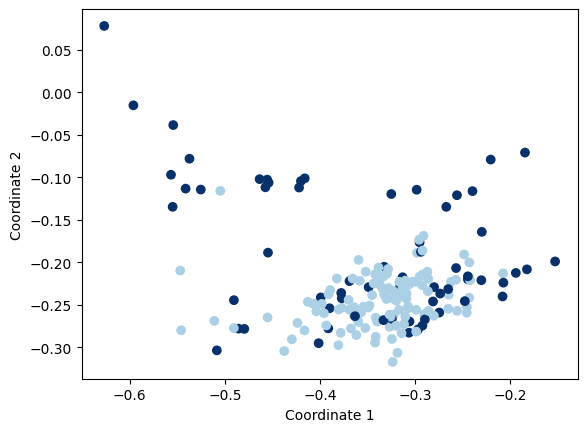

In [5]:
id_to_plot = 10

plt.scatter(coordinates_PCA[match_array == id_to_plot][:,0], coordinates_PCA[match_array == id_to_plot][:,1], c=event_array[match_array == id_to_plot], vmin=-0.5, vmax=1, cmap='Blues')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

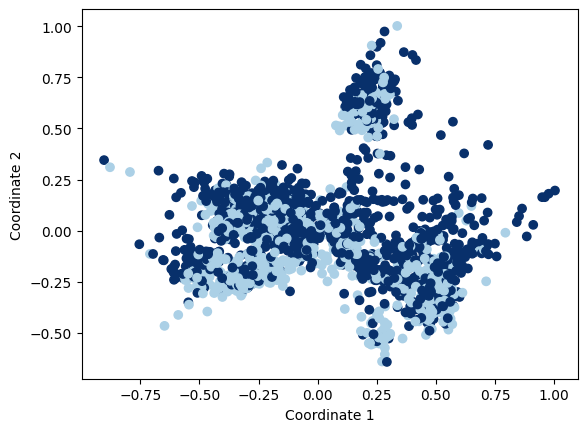

In [6]:
plt.scatter(coordinates_PCA[:,0], coordinates_PCA[:,1], c=event_array, vmin=-0.5, vmax=1, cmap='Blues')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

## Separate Train and Test data

In [7]:
# Train on of the first 13 of 16 matches (16*0.8=12.8~=13)
# and the test data would be the last 3 matches. 
# Before submitting on Kaggle we should train on full dataset, so al 16 matches
train_percentage = 0.8
unique_match_ids = df['MatchID'].unique()
num_matches_training = int(ceil(len(unique_match_ids)*train_percentage))

In [8]:
# All matches from num_matches_training and after will be in test test
# row_index is then the first row of the matches that will go to the test


row_index = (df['MatchID'] == num_matches_training).idxmax()
df_X_train = df[:row_index].copy()
df_X_test = df[row_index:].copy()


In [9]:
df_y_train = df_X_train['EventType']
df_y_train

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1482    1.0
1483    0.0
1484    0.0
1485    1.0
1486    1.0
Name: EventType, Length: 1487, dtype: float64

In [10]:
df_y_test = df_X_test['EventType']
df_y_test.reset_index(drop=True, inplace=True)
df_y_test

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
645    1.0
646    1.0
647    1.0
648    1.0
649    1.0
Name: EventType, Length: 650, dtype: float64

In [11]:
df_X_train.drop(['EventType'], axis=1, inplace=True)
df_X_train

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,0.107778,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,0.074244,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,0.082248,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,0.073075,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,0.009802,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,12,92,12_92,0.145892,0.222630,0.120081,-0.116945,0.024491,0.009698,0.137669,...,-0.224321,-0.143763,0.020284,0.018604,-0.082488,0.076500,0.234800,0.126446,-0.053445,0.130328
1483,12,93,12_93,0.153782,0.227837,0.096260,-0.097191,0.040159,-0.006013,0.112964,...,-0.231501,-0.134865,0.019563,0.001825,-0.100477,0.059753,0.218688,0.120353,-0.046471,0.139495
1484,12,94,12_94,0.132877,0.225982,0.112246,-0.112541,0.027943,0.009418,0.120520,...,-0.215114,-0.125932,0.020598,-0.012168,-0.092944,0.057864,0.243887,0.117850,-0.046737,0.132410
1485,12,95,12_95,0.121008,0.233462,0.137019,-0.118832,0.069999,0.016348,0.101057,...,-0.202068,-0.163163,0.043706,0.024385,-0.094716,0.110365,0.294361,0.131040,-0.043662,0.119831


In [12]:
df_X_test.drop(['EventType'], axis=1, inplace=True)
df_X_test.reset_index(drop=True, inplace=True)
df_X_test

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,13,0,13_0,0.122759,0.217809,0.033307,-0.081587,-0.090911,0.004376,0.115224,...,-0.097398,-0.126960,0.061238,-0.010634,-0.073343,0.062516,0.167249,0.021082,0.089660,0.088117
1,13,1,13_1,0.137794,0.241211,0.032959,-0.080467,-0.093196,0.008602,0.108653,...,-0.097439,-0.122606,0.051559,-0.013713,-0.078115,0.064444,0.165768,0.029060,0.085954,0.088108
2,13,2,13_2,0.146005,0.245907,0.001561,-0.068743,-0.051985,0.006599,0.125866,...,-0.124040,-0.102845,0.055133,0.015766,-0.066953,0.052463,0.126224,0.038286,0.051691,0.116719
3,13,3,13_3,0.140378,0.245704,-0.006743,-0.065213,-0.058203,0.009926,0.117768,...,-0.127208,-0.100219,0.061303,0.022392,-0.068072,0.050457,0.120086,0.027437,0.044498,0.110755
4,13,4,13_4,0.140965,0.249176,0.005743,-0.071034,-0.063098,0.012924,0.122345,...,-0.125824,-0.104658,0.069917,0.022122,-0.067908,0.056947,0.121216,0.018840,0.038354,0.106161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,19,125,19_125,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,-0.099700,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
646,19,126,19_126,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,-0.069458,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
647,19,127,19_127,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,-0.068634,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
648,19,128,19_128,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,-0.066234,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


In [13]:
def convert_df_to_2D_np_array(df_X, df_y):
    df_X_noID = df_X.copy()
    df_X_noID.drop(['MatchID', 'ID', 'PeriodID'], axis=1, inplace=True)
    X_train = df_X_noID.to_numpy()
    y_train = df_y.to_numpy()
    return X_train, y_train

In [14]:
X_train_2D, y_train_2D = convert_df_to_2D_np_array(df_X_train, df_y_train)
X_test_2D, y_test_2D = convert_df_to_2D_np_array(df_X_test, df_y_test)
X_train_2D_normalized = normalize(X_train_2D[:,1:], axis=1, norm='l2')
X_test_2D_normalized = normalize(X_test_2D[:,1:], axis=1, norm='l2')
print(X_train_2D.shape)
print(X_test_2D.shape)

(1487, 200)
(650, 200)


## Testing on KNN

In [15]:
n_neighbors_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

best_accuracy = 0
best_n_neighbors = 0

for n_neighbors in n_neighbors_list:
    knn_model = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train_2D_normalized, y_train_2D)
    y_test_predict = knn_model.predict(X_test_2D_normalized)
    y_train_predict = knn_model.predict(X_train_2D_normalized)
    accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
    train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
    print(f"Training with {n_neighbors} nn. Accuracy on training set: {train_accuracy:.4f} Accuracy on testing set: {accuracy:.4f}")
    if (best_accuracy < accuracy):
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

print(f"Best results with {best_n_neighbors} nn! Accuracy on testing set: {best_accuracy:.4f}")

Training with 3 nn. Accuracy on training set: 0.8736 Accuracy on testing set: 0.5846
Training with 4 nn. Accuracy on training set: 0.8447 Accuracy on testing set: 0.5523
Training with 5 nn. Accuracy on training set: 0.8440 Accuracy on testing set: 0.5523
Training with 6 nn. Accuracy on training set: 0.8144 Accuracy on testing set: 0.5415
Training with 7 nn. Accuracy on training set: 0.8110 Accuracy on testing set: 0.5462
Training with 8 nn. Accuracy on training set: 0.7875 Accuracy on testing set: 0.5492
Training with 9 nn. Accuracy on training set: 0.7841 Accuracy on testing set: 0.5631
Training with 10 nn. Accuracy on training set: 0.7660 Accuracy on testing set: 0.5415
Training with 11 nn. Accuracy on training set: 0.7714 Accuracy on testing set: 0.5738
Training with 12 nn. Accuracy on training set: 0.7606 Accuracy on testing set: 0.5569
Training with 13 nn. Accuracy on training set: 0.7606 Accuracy on testing set: 0.5785
Training with 14 nn. Accuracy on training set: 0.7478 Accurac

In [16]:
df_cleaned = df.copy()
df_cleaned.drop(["MatchID", "ID", "EventType"], axis=1, inplace=True)
data_array = df_cleaned.to_numpy()
X_train_2D_similarity = np.sqrt(X_train_2D_normalized @ X_train_2D_normalized.T)
X_test_2D_similarity = np.sqrt(X_test_2D_normalized @ X_test_2D_normalized.T)
X_train_PCA = PCA().fit_transform(X_train_2D_similarity)
X_test_PCA = PCA().fit_transform(X_test_2D_similarity)

n_neighbors_list = [3, 4, 5, 6, 7, 8, 9, 10]
number_components_list = [30, 40, 50, 75, 100, 150, 201]

best_accuracy = 0
best_n_neighbors = 0
best_number_components = 0

for n_neighbors in n_neighbors_list:
    for number_components in number_components_list:
        knn_model = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train_PCA[:,:number_components], y_train_2D)
        y_test_predict = knn_model.predict(X_test_PCA[:,:number_components])
        y_train_predict = knn_model.predict(X_train_PCA[:,:number_components])
        accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
        train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
        print(f"Training with {n_neighbors} nn and {number_components} components. Accuracy on training set: {train_accuracy:.4f} Accuracy on testing set: {accuracy:.4f}")
        if (best_accuracy < accuracy):
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_number_components = number_components

print(f"Best results with {best_n_neighbors} nn and {best_number_components} components! Accuracy on testing set: {best_accuracy:.4f}")

Training with 3 nn and 30 components. Accuracy on training set: 0.8581 Accuracy on testing set: 0.4262
Training with 3 nn and 40 components. Accuracy on training set: 0.8581 Accuracy on testing set: 0.4262
Training with 3 nn and 50 components. Accuracy on training set: 0.8594 Accuracy on testing set: 0.4262
Training with 3 nn and 75 components. Accuracy on training set: 0.8594 Accuracy on testing set: 0.4277
Training with 3 nn and 100 components. Accuracy on training set: 0.8594 Accuracy on testing set: 0.4277
Training with 3 nn and 150 components. Accuracy on training set: 0.8594 Accuracy on testing set: 0.4277
Training with 3 nn and 201 components. Accuracy on training set: 0.8594 Accuracy on testing set: 0.4277
Training with 4 nn and 30 components. Accuracy on training set: 0.8231 Accuracy on testing set: 0.4292
Training with 4 nn and 40 components. Accuracy on training set: 0.8218 Accuracy on testing set: 0.4292
Training with 4 nn and 50 components. Accuracy on training set: 0.8225

## Decision Tree, Tree Bagging & Random Forest models

In [17]:
nb_cross_validation = 5

DT_model = DecisionTreeClassifier(random_state=0)
p_grid_DT = {'min_samples_split': [15, 20, 25, 30], 'min_samples_leaf': [2, 4, 6, 8, 10] }

grid_DT = GridSearchCV(estimator=DT_model, param_grid=p_grid_DT, scoring='accuracy', cv=nb_cross_validation)
grid_DT.fit(X_train_2D, y_train_2D)

print("Cross validation done on Decision Tree!")
print("Best accuracy: {}".format(grid_DT.best_score_))
print("Best params: {}".format(grid_DT.best_params_))

Cross validation done on Decision Tree!
Best accuracy: 0.5911463629584435
Best params: {'min_samples_leaf': 10, 'min_samples_split': 25}


In [18]:
best_params = grid_DT.best_params_

DT_model = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
DT_model.fit(X_train_2D, y_train_2D)
y_test_predict = DT_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4646


In [19]:
p_grid_bagging = {'n_estimators': [12, 14, 16, 18, 20]}   
Bagging_model = BaggingClassifier(estimator=DT_model, random_state=0)
grid_bagging = GridSearchCV(estimator=Bagging_model, param_grid=p_grid_bagging, scoring="accuracy", cv=nb_cross_validation)
grid_bagging.fit(X_train_2D, y_train_2D)

print("Cross validation done on Tree Bagging!")
print("Best accuracy: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))

Cross validation done on Tree Bagging!
Best accuracy: 0.6475899938987187
Best params: {'n_estimators': 14}


In [20]:
best_params = grid_bagging.best_params_

Bagging_model = BaggingClassifier(estimator=DT_model, n_estimators=best_params["n_estimators"], random_state=0)
Bagging_model.fit(X_train_2D, y_train_2D)
y_test_predict = Bagging_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5846


In [21]:
nb_cross_validation = 5

RF_model = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF_model, param_grid=p_grid_RF, scoring='accuracy', cv=nb_cross_validation)
grid_RF.fit(X_train_2D, y_train_2D)

print("Cross validation done on Random Forest!")
print("Best accuracy: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Cross validation done on Random Forest!
Best accuracy: 0.6415248683705059
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 35}


In [22]:
best_params = grid_RF.best_params_

RF_model = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF_model.fit(X_train_2D, y_train_2D)
y_test_predict = RF_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6369


## Test with XGBR and LGBMR

In [23]:
n_estimators_list = [10, 20, 50, 100, 200]
max_depth_list = [1, 2, 3]
learning_rate_list = [0.05, 0.1, 0.15, 0.2, 0.3]

best_params = [0, 0]
best_accuracy = 0

for n_estimator in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            xgbr = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate).fit(X_train_2D, y_train_2D)
            y_test_predict = (xgbr.predict(X_test_2D) > 0.5)
            y_train_predict = (xgbr.predict(X_train_2D) > 0.5)
            accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
            train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
            print(f"Nb estimators: {n_estimator} Max depth: {max_depth} Learning rate: {learning_rate}")
            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_params = [n_estimator, max_depth, learning_rate]

print("")
print(f"Best accuracy on testing set: {best_accuracy:.4f}")
print(f"Best parameters:\nNb estimators: {best_params[0]} Max depth: {best_params[1]} Learning rate: {best_params[2]}")

Nb estimators: 10 Max depth: 1 Learning rate: 0.05
Nb estimators: 10 Max depth: 1 Learning rate: 0.1
Nb estimators: 10 Max depth: 1 Learning rate: 0.15
Nb estimators: 10 Max depth: 1 Learning rate: 0.2
Nb estimators: 10 Max depth: 1 Learning rate: 0.3
Nb estimators: 10 Max depth: 2 Learning rate: 0.05
Nb estimators: 10 Max depth: 2 Learning rate: 0.1
Nb estimators: 10 Max depth: 2 Learning rate: 0.15
Nb estimators: 10 Max depth: 2 Learning rate: 0.2
Nb estimators: 10 Max depth: 2 Learning rate: 0.3
Nb estimators: 10 Max depth: 3 Learning rate: 0.05
Nb estimators: 10 Max depth: 3 Learning rate: 0.1
Nb estimators: 10 Max depth: 3 Learning rate: 0.15
Nb estimators: 10 Max depth: 3 Learning rate: 0.2
Nb estimators: 10 Max depth: 3 Learning rate: 0.3
Nb estimators: 20 Max depth: 1 Learning rate: 0.05
Nb estimators: 20 Max depth: 1 Learning rate: 0.1
Nb estimators: 20 Max depth: 1 Learning rate: 0.15
Nb estimators: 20 Max depth: 1 Learning rate: 0.2
Nb estimators: 20 Max depth: 1 Learning ra

In [ ]:
n_estimators_list = [100, 200, 300, 400, 500]
max_depth_list = [1, 2, 3, 4, 5]
learning_rate_list = [0.01, 0.05, 0.1, 0.15]

best_params = [0, 0]
best_accuracy = 0

for n_estimator in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            lgbmr = LGBMRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate).fit(X_train_2D, y_train_2D)
            y_test_predict = (lgbmr.predict(X_test_2D) > 0.5)
            y_train_predict = (lgbmr.predict(X_train_2D) > 0.5)
            accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
            train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
            print(f"Nb estimators: {n_estimator} Max depth: {max_depth} Learning rate: {learning_rate}")
            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_params = [n_estimator, max_depth, learning_rate]

print("")
print(f"Best accuracy on testing set: {best_accuracy:.4f}")
print(f"Best parameters:\nNb estimators: {best_params[0]} Max depth: {best_params[1]} Learning rate: {best_params[2]}")

# Application of the model (Kaggle submissions)

## Prepare the datasets

In [25]:
df_X = pd.concat([df_X_train, df_X_test], ignore_index=True)
df_y = pd.concat([df_y_train, df_y_test], ignore_index=True)
print(df_X['MatchID'].unique())
print(df_X.shape)
print(df_y.shape)
df_X

[ 0  1  2  3  4  5  7  8 10 11 12 13 14 17 18 19]
(2137, 203)
(2137,)


,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,0.107778,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,0.074244,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,0.082248,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,0.073075,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,0.009802,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,-0.099700,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,-0.069458,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,-0.068634,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,-0.066234,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


In [26]:
df_eval = pd.read_feather("processed_data/eval_tweets_processed.feather")
df_y_eval = pd.Series(0, index=df_eval.index)

df_eval

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6,0,6_0,0.158896,0.264814,0.057981,-0.102842,0.061002,0.023203,0.131890,...,-0.184701,-0.101496,0.081690,-0.004283,-0.057534,0.006105,0.171110,0.025386,-0.039204,0.189157
1,6,1,6_1,0.156288,0.271375,0.059343,-0.108422,0.052298,0.019057,0.119804,...,-0.193451,-0.098110,0.085782,-0.014780,-0.065975,0.008123,0.176577,0.028697,-0.037489,0.189704
2,6,2,6_2,0.145923,0.240633,0.057680,-0.104799,0.108712,0.009395,0.081510,...,-0.200057,-0.118543,0.082504,-0.064201,-0.029714,0.073884,0.186111,0.105346,-0.022998,0.202353
3,6,3,6_3,0.160460,0.285798,0.063682,-0.104289,0.061716,0.016656,0.126485,...,-0.188633,-0.087426,0.102778,-0.018449,-0.064665,0.006555,0.178324,0.028487,-0.038289,0.191645
4,6,4,6_4,0.159856,0.281828,0.073446,-0.112441,0.063491,0.021445,0.110178,...,-0.178722,-0.094382,0.093599,-0.025704,-0.076860,0.015346,0.189978,0.027995,-0.040230,0.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,16,125,16_125,0.090554,0.227452,0.107798,-0.111091,0.034236,0.063783,0.053129,...,-0.198507,-0.122853,0.024147,0.000304,-0.161041,0.092954,0.143728,0.113752,-0.049263,0.056543
512,16,126,16_126,0.086859,0.236306,0.107814,-0.125368,0.026619,0.063352,0.062930,...,-0.189677,-0.125140,0.027448,0.003508,-0.144993,0.096095,0.155616,0.101075,-0.042474,0.058476
513,16,127,16_127,0.096795,0.220505,0.109566,-0.119462,0.023341,0.063660,0.084856,...,-0.180416,-0.117967,0.033671,0.007132,-0.137807,0.088667,0.160295,0.102587,-0.045250,0.052347
514,16,128,16_128,0.090397,0.227700,0.104989,-0.123692,0.035497,0.059867,0.049117,...,-0.188227,-0.115212,0.019899,0.006688,-0.167376,0.096072,0.149536,0.122288,-0.047816,0.063510


In [27]:
X_final_train_2D, y_final_train_2D = convert_df_to_2D_np_array(df_X, df_y)
X_eval_2D, _ = convert_df_to_2D_np_array(df_eval, df_y_eval)
X_final_train_2D_normalized = normalize(X_final_train_2D, axis=1, norm='l2')
X_eval_2D_normalized = normalize(X_eval_2D, axis=1, norm='l2')
print(X_final_train_2D.shape)
print(y_final_train_2D.shape)
print(X_eval_2D.shape)

(2137, 200)
(2137,)
(516, 200)


## Evaluating KNN, Random Forest, XGBR and LGBMR

In [28]:
n_neighbors = 3

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_final_train_2D_normalized, y_final_train_2D)
y_eval_predict = knn_model.predict(X_eval_2D_normalized)

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "test_submissions/Submission KNN " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [29]:
n_estimators = 35
min_samples_leaf = 5
max_features = 'sqrt'

RF_model = RandomForestClassifier(min_samples_leaf=min_samples_leaf,max_features=max_features,n_estimators=n_estimators, random_state=0)
RF_model.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = RF_model.predict(X_eval_2D)

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "test_submissions/Submission RF " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [30]:
n_estimator = 100
max_depth = 1
learning_rate = 0.15
xgbr = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate)
xgbr.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = (xgbr.predict(X_eval_2D) > 0.5).astype(float)

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "test_submissions/Submission XGBR " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [ ]:
n_estimator = 500
max_depth = 1
learning_rate = 0.1
lgbmr = LGBMRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate)
lgbmr.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = (lgbmr.predict(X_eval_2D) > 0.5).astype(float)

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "test_submissions/Submission LGBMR " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)